In [1]:
import json, sys, math
from IPython.display import Image, display
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages')

### Fitting a 2D surface 
The axes are wavelength (microns) and time (days). 
The functions are exponential in time (linear in magnitude) times blackbody; 
and Bazin in time (exp rise then exp fall) times blackbody.

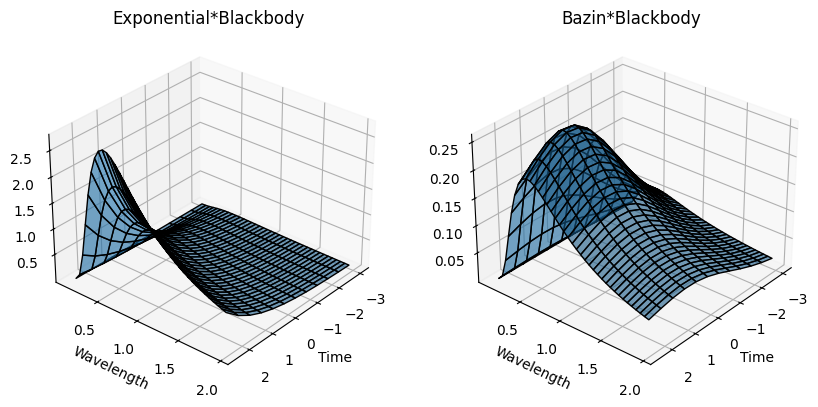

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

T = 5   # Just choose arbitrary temperature 5,000 Kelvin
def blackbody(wl, T):
    hck = 14.387
    q = np.exp(hck/(wl*T))
    return np.power(wl, -3.0) /(q - 1)
def bazinBB(tau, wl):
    T = 10
    kr = 1
    kf = 0.3
    ef = np.exp(-kf*tau)
    er = np.exp(-kr*tau)
    return blackbody(wl, T) * ef/(1+er)
def expBB(tau, wl):
    T = 10
    k = 0.7
    er = np.exp(k*tau)
    return blackbody(wl, T) * er

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.azim = ax2.azim = 40
tau = np.arange(-3, 3, 0.5)
wl  = np.arange(0.1, 2.0, 0.05)
Tau, Wl = np.meshgrid(tau, wl)

zs = np.array(expBB(np.ravel(Tau), np.ravel(Wl)))
Z = zs.reshape(Tau.shape)
ax1.plot_surface(Tau, Wl, Z, edgecolors='k', alpha=.6)
ax1.set_xlabel('Time')
ax1.set_ylabel('Wavelength')
ax1.set_title('Exponential*Blackbody')

zs = np.array(bazinBB(np.ravel(Tau), np.ravel(Wl)))
Z = zs.reshape(Tau.shape)
ax2.plot_surface(Tau, Wl, Z, edgecolors='k', alpha=.6)
ax2.set_xlabel('Time')
ax2.set_ylabel('Wavelength')
ax2.set_title('Bazin*Blackbody')

plt.show()

### Fitting a lightcurve
To run this code, you need `pip install BazinBlackBody`

In [9]:
# Here is a fake alert
objectId = 99999999999
file = 'json/%d.json'%objectId
alert = json.loads(open(file).read())

discoveryMJD = alert['diaSourcesList'][0]['midpointMjdTai']
print(discoveryMJD)

60585.488921153905


The return from the fitting is a pair. It tries to fit both ExpBB and BazinBB. Each dictionary carries 
the fitting paramters, and also `Rsq`, the remaining variance after the fit, compared to the variance about the mean.
The fit with lowest `Rsq` is the best one.

In [4]:
from bazinBlackBody import BBBEngine
BE = BBBEngine.BBB('LSST', verbose=False)
(dicte, dictb) =  BE.make_fit(alert)

Rsq fit is 0.1794


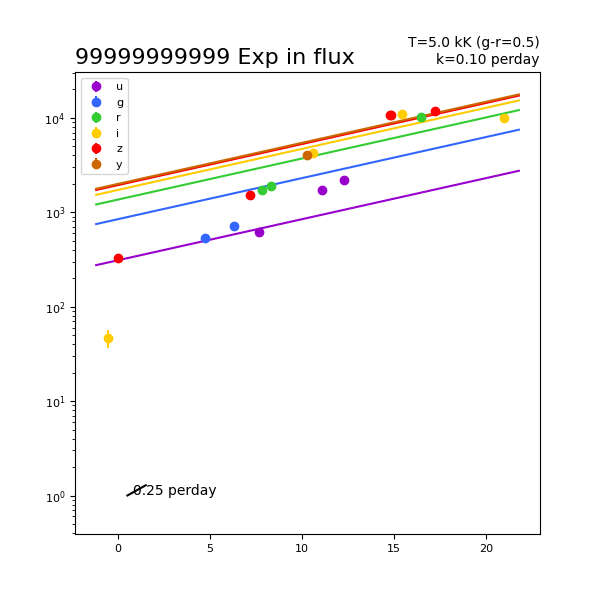

In [5]:
if dicte:
    print('Rsq fit is %.4f' % dicte['Rsq'])
    filename = 'image/%d_e.png'%objectId
    BE.plot(alert, dicte, filename)
    display(Image(filename=filename))

{'npoint': 19, 'Rsq': 0.0003732339420449371, 'A': 199764.59009526335, 'T': 5.970811352054309, 't0': 14.362068721406596, 'kr': 0.4516572631249752, 'kf': 0.09735144516043781, 'Aerr': 748.4512998878822, 'Terr': 0.004452763238357789, 't0err': 0.024050410333637112, 'krerr': 0.000550997540150741, 'kferr': 0.0007318431781909044, 'post_discovery': 20.996849335700972, 'tns_name': ''}
Rsq fit is 0.0004


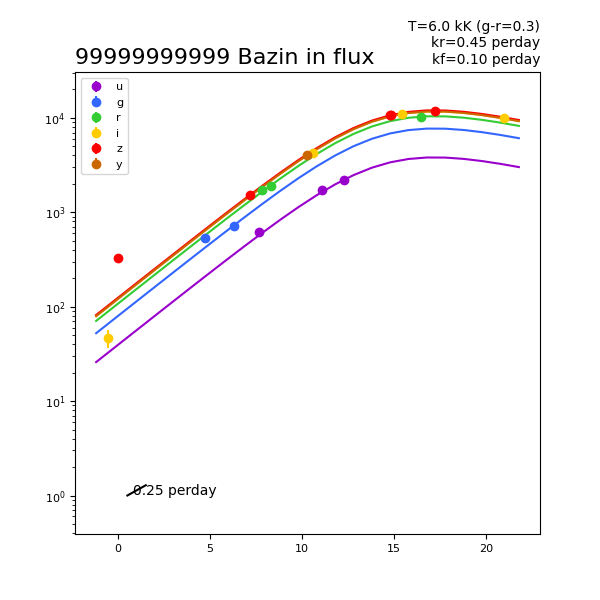

In [8]:
if dictb:
    print(dictb)
    
    
    print('Rsq fit is %.4f' % dictb['Rsq'])
    filename = 'image/%d_b.png'%objectId
    BE.plot(alert, dictb, filename)
    display(Image(filename=filename))

In [7]:
if dicte and dictb:
    if dicte['Rsq'] < dictb['Rsq']:
        print('Best fit is Exponential*BlackBody')
    else:
        print('Best fit is Bazin*BlackBody')

Best fit is Bazin*BlackBody
